In [124]:
import numpy as np # type: ignore
import random
import copy
import matplotlib.pyplot as plt # type: ignore

In [125]:
class Problem:
    def __init__(self, profit, weight, capacity):
        self.profit = profit
        self.weight = weight
        self.capacity = capacity

In [126]:
def decode(chromosome):
    chr = chromosome.tolist()
    return np.array([0 if gen < 0.5 else 1 for gen in chr])

def get_fitness(chromosome, problem : Problem):
    solution = decode(chromosome)
    total_profit = np.sum(solution * problem.profit)
    total_weight = np.sum(solution * problem.weight)
    if total_weight > problem.capacity:
        return 0
    else:
        return total_profit
    

In [127]:
class Individual:
    def __init__(self):
        self.chromosome = None
        self.fitness = None
        self.velocity = None
        self.bestFitness = None
        self.bestPosition = None

    def genIndi(self, problem : Problem):
        num_item = problem.profit.size
        self.chromosome = np.random.uniform(0.0, 1.0, num_item)
    
    def cal_fitness(self, problem):
        self.fitness = get_fitness(self.chromosome, problem)
    
    def clone(self):
        return copy.deepcopy(self)
    
    def __repr__(self):
        return f"chromosome={self.chromosome}, fitness={self.fitness}" 


In [128]:
def neighbors(indi, delta):
    list_indi = []
    neighbor = indi
    for i in range(len(indi.chromosome)):
        neighbor.chromosome[i] -= delta
        list_indi.append(neighbor.clone())
        neighbor.chromosome[i] += delta
    
    for i in range(len(indi.chromosome)):
        neighbor.chromosome[i] += delta
        list_indi.append(neighbor.clone())
        neighbor.chromosome[i] -= delta
    
    return list_indi

In [129]:
def select(list_indi, problem):
    for indi in list_indi:
        indi.cal_fitness(problem)
    return max(list_indi, key=lambda indi: indi.fitness)

In [130]:
# Simulated binary crossover - SBX
def crossover(parent1, parent2, problem : Problem, eta = 2.0):
    off1 = Individual()
    off2 = Individual()
    r = np.random.rand()
    if (r <= 0.5):
        beta = (2*r)**(1.0/(eta + 1))
    else:
        beta = (1.0/(2*(1 - r)))**(1.0/(eta + 1))
    p1 = parent1.chromosome
    p2 = parent2.chromosome
    c1 = 0.5 * ((1 + beta) * p1 + (1 - beta) * p2)
    c2 = 0.5 * ((1 - beta) * p1 + (1 + beta) * p2)
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    off1.chromosome = c1
    off2.chromosome = c2
    return off1.clone(), off2.clone()

In [131]:
# Polynomial mutaion - PM
def mutation(indi, eta = 20.0):
    chr = indi.chromosome
    for i in range(chr.size):
        mu = np.random.rand()
        if (mu <= 0.5):
            delta = (2 * mu)**(1.0/(1 + eta)) - 1
            chr[i] = chr[i] + delta * chr[i]
        else:
            delta = 1 - (2 - 2*mu)**(1.0/(1 + eta))
            chr[i] = chr[i] + delta * (1 - chr[i])
            
    chr = np.clip(chr, 0.0, 1.0)
    indi.chromosome = chr
    return indi.clone()

In [132]:
class Population:
    def __init__(self, pop_size, problem : Problem):
        self.pop_size = pop_size
        self.list_indi = []
        self.problem = problem
    
    def genPop(self):
        for i in range(self.pop_size):
            indi = Individual()
            indi.genIndi(self.problem)
            indi.cal_fitness(self.problem)
            self.list_indi.append(indi)

    def show(self):
        for indi in self.list_indi:
            print(indi)

In [133]:
def selection(list, k = 2):
    tour1 = random.sample(list, k)
    tour2 = random.sample(list, k)
    x = max(tour1, key=lambda indi: indi.fitness)
    y = max(tour2, key=lambda indi: indi.fitness)
    return x.clone(), y.clone()

In [134]:
def survival_selection(list, pop_size):
    list = sorted(list, key=lambda indi: indi.fitness, reverse=True)
    list = list[0: pop_size]
    return list

In [135]:
def GA_LS(problem, pop_size, max_gen, p_c, p_m, delta):
    pop = Population(pop_size, problem)
    pop.genPop()
    history = []
    for i in range(max_gen):
        child = []
        while (len(child) < pop_size):
            p1, p2 = selection(pop.list_indi)
            if np.random.rand() <= p_c:
                c1, c2 = crossover(p1, p2, problem)
                c1.cal_fitness(problem)
                c2.cal_fitness(problem)
                child.append(c1)
                child.append(c2)
            if np.random.rand() <= p_m:
                p1 = mutation(p1)
                p2 = mutation(p2)
                p1.cal_fitness(problem)
                p2.cal_fitness(problem)
                child.append(p1)
                child.append(p2)
        pop.list_indi = survival_selection(pop.list_indi + child, pop_size)
        history.append(pop.list_indi[0].fitness)
    print(f"GA: Best fitness {history[-1]}")
    best = Individual()
    for i in range(max_gen):
        best = max(pop.list_indi, key=lambda indi: indi.fitness)
        history.append(best.fitness)
        for i in range(len(pop.list_indi)):
            list_indi = neighbors(pop.list_indi[i], delta)
            pop.list_indi[i] = select(list_indi, problem)  
    print(f"LS: Best fitness {history[-1]}")    
    return history, best


In [136]:
def KP(problem : Problem):
    profit = problem.profit
    weight = problem.weight
    capacity = problem.capacity
    precision = 100  # Hệ số xấp xỉ: càng lớn thì càng chính xác, nhưng tốn RAM/CPU hơn
    n = len(profit)

    # Chuyển trọng lượng và capacity sang số nguyên
    int_weight = [int(w * precision) for w in weight]
    int_capacity = int(capacity * precision)

    # Tạo bảng DP
    dp = [[0.0 for _ in range(int_capacity + 1)] for _ in range(n + 1)]

    # Quy hoạch động
    for i in range(1, n + 1):
        for w in range(int_capacity + 1):
            if int_weight[i - 1] <= w:
                dp[i][w] = max(profit[i - 1] + dp[i - 1][w - int_weight[i - 1]], dp[i - 1][w])
            else:
                dp[i][w] = dp[i - 1][w]

    return dp[n][int_capacity]

In [137]:
# setup
profit = np.random.uniform(5.0, 20.0, 20)
weight = np.random.uniform(2.0, 20.0, 20)
capacity = np.random.uniform(0.0, np.sum(weight))
# profit = np.array([3, 6, 8, 10, 15])
# weight = np.array([2, 3, 3, 5, 8])
# capacity = 10
problem = Problem(profit, weight, capacity)

pop_size = 10
max_gen = 100
Pc = 0.9
Pm = 0.2
delta = 0.05
# start
fitness_history, solution = GA_LS(problem, pop_size, max_gen, Pc, Pm, delta)

#show
# for i in range(len(fitness_history)):
#     print(f"Generation {i}, bestfitness = {fitness_history[i]:.2f}")


GA: Best fitness 0
LS: Best fitness 76.28694018523848


In [138]:
#show
np.set_printoptions(precision=2, suppress=True)
print("solution:")
print(decode(solution.chromosome))
print(f"{solution.fitness:.2f}")

solution:
[0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0]
76.29


In [139]:
print(KP(problem))

109.26514251982647


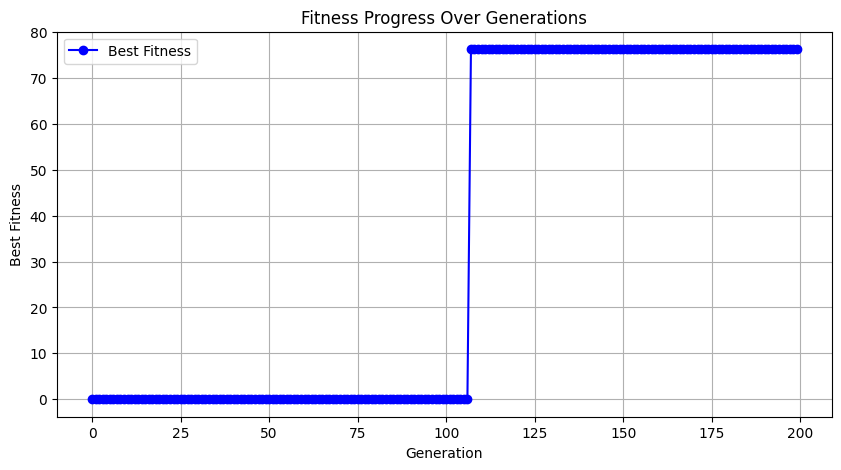

In [140]:
generations = list(range(len(fitness_history)))
plt.figure(figsize=(10, 5))
plt.plot(generations, fitness_history, marker='o', linestyle='-', color='b', label='Best Fitness')

plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Fitness Progress Over Generations")
plt.legend()
plt.grid(True)
plt.show()